## Advanced Lane Finding Project¶
#### The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

#### 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

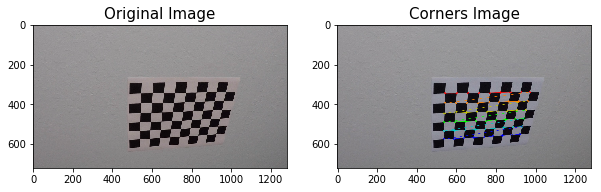

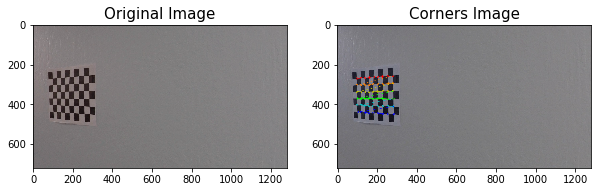

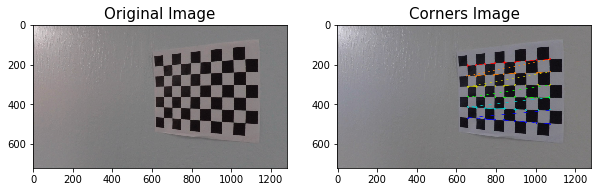

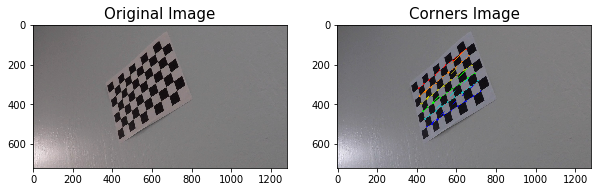

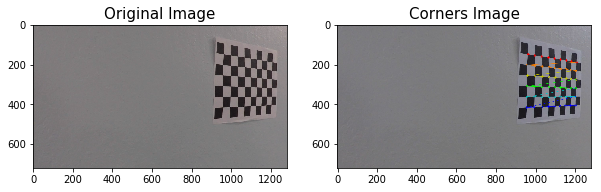

In [2]:
import glob

nx = 9
ny = 6

# arrays to store object points and image points from all the images.
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# prepare object points
objp = np.zeros((6*9, 3), np.float32) # same 3D from (0,0,0) to (7,5,0)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x,y coord; mgrid returns coord values 

images = glob.glob('camera_cal/calibration*.jpg')
i = 0
for _, fname in enumerate(images):
    if i>5: break
    i+=1
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Corners Image', fontsize=15)
        
    plt.show()

#### 2. Apply a distortion correction to raw images.

#### 3. Use color transforms, gradients, etc., to create a thresholded binary image.


#### 4. Apply a perspective transform to rectify binary image ("birds-eye view").


#### 5. Detect lane pixels and fit to find the lane boundary.


# Start 1

In [435]:
# thresholded_binary
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)): # (40,100)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
    if orient=='x': abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient=='y': abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # rescale 8-bit
    sobel_binary = np.zeros_like(scaled_sobel) # create a copy and apply threshold
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_binary

def HLS_thresh(img, thresh=(0, 255)): # (170,255) (150,255) (180, 255)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    ch = hls[:,:,2] # saturation
    hls_binary = np.zeros_like(ch)
    hls_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    return hls_binary

def HSV_thresh(img, thresh=(0,255)):
    hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
    ch = hsv[:,:,2] # value
    hsv_binary = np.zeros_like(ch)
    hsv_binary[(ch > thresh[0]) & (ch <= thresh[1])] = 1
    return hsv_binary

def LUV_thresh(img, thresh=(0,255)):
    luv = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    ch = luv[:,:,0] 
    luv_binary = np.zeros_like(ch)
    luv_binary[(ch >= thresh[0]) & (ch <= thresh[1])]
    return luv_binary
    
def LAB_thresh(img, thresh=(0,255)):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab) # convert RGB to floating-point format and scaled to fit the 0 to 1 range.
    lab2 = lab[:,:,2]
    # if np.max(lab2) > 175: # skip normalizing if no yellows available in the image.
    #    lab2 = lab2*(255/np.max(lab2))
    lab_binary = np.zeros_like(lab2)
    lab_binary[((lab2 >= thresh[0]) & (lab2 <= thresh[1]))] = 1
    return lab_binary

def lightness_mask(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    saturation = hls[:,:,2]
    lightness = hls[:,:,1]
    lightness_binary = np.zeros_like(saturation)
    lightness_binary[(saturation >=thresh[0]) & (lightness>=thresh[1])] = 1
    return lightness_binary

def combined_gradient_thresholds(img): # img: undistorted image
    sobelx_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=5, thresh=(40,100))
    saturation_binary = HLS_thresh(img, thresh=(120,255))
    value_binary = HSV_thresh(img, thresh=(75,255))
    luv_binary = LUV_thresh(img, thresh=(225,255))
    lightness_binary = lightness_mask(img, thresh=(5,130))
    lab_binary = LAB_thresh(img, thresh=(155,200))
    combined_binary = np.zeros_like(sobelx_binary)
    # combined_binary[(sobelx_binary==1) | (saturation_binary==1) & (value_binary==1)]=1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1)]=1 #### OK-8
#     combined_binary[(luv_binary==1) | (lab_binary==1)]=1 ### OK-9
    combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1)]=1
    
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1)] = 1
    return combined_binary

#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) | (lab_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) | (lightness_binary==1) | (lab_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) | (lightness_binary==1) | (lab_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) | (lightness_binary==1) | (lab_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) | (lab_binary==1)] = 1
#     combined_binary[(saturation_binary==1) | (sobelx_binary==1) & (value_binary==1) & (lightness_binary==1)] = 1
#     combined_binary[(luv_binary==1) | (lab_binary==1) | (saturation_binary==1) | (lightness_binary==1)] = 1
#     return combined_binary


def undistorted_correction(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def get_perspective_transform(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warped

def bird_eye_perspective(img, src, dst):
    undist = undistorted_correction(img, objpoints, imgpoints) # undistorted image
    M, Minv, warped = get_perspective_transform(undist, src, dst)
    return M, Minv, warped, undist

def apply_binary(img, src, dst):
    M, Minv, warped, undist = bird_eye_perspective(img, src, dst) # warped image is undistorte and warped.
    combined_binary = combined_gradient_thresholds(warped) # sobelx+saturation+value
    return combined_binary, warped, M, Minv, undist



(720, 1280)


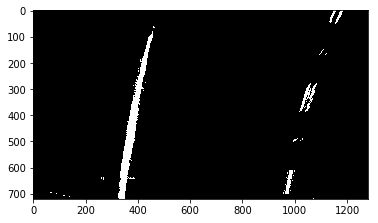

In [439]:
img = mpimg.imread('test_images/test3.jpg')
# src = np.float32([[500, 485],[810, 485],
#                       [1250, 720],[50, 720]])
# dst = np.float32([[0, 0], [1280, 0], 
#                  [1250, 720],[50, 720]])

src = np.float32([[585,460], [203,720],
            [1127,720], [695,460]])
dst = np.float32([[320,0], [320,720],
            [960,720], [960,0]])

combined_binary, warped, M, Minv, undist = apply_binary(img, src, dst)
print(combined_binary.shape)
plt.imshow(combined_binary, cmap='gray')




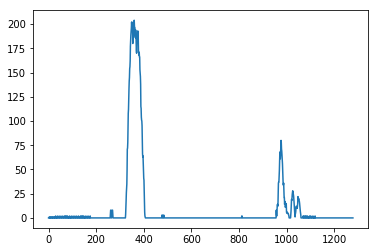

In [440]:
histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [460]:
def find_lane_lines(combined_binary):
    histogram = np.sum(combined_binary[combined_binary.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
#     out_img[lefty, leftx] = [255,0,0]
#     out_img[righty,rightx] = [0,0,255]
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(combined_binary.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
#     global glb_left_fit, glb_right_fit
#     glb_left_fit = left_fit
#     glb_right_fit = right_fit
#     if ((glb_left_fit is None) and (glb_left_fit is None)):
        # Step through the windows one by one
    global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
    if detected_line==False:
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = combined_binary.shape[0] - (window+1)*window_height
            win_y_high = combined_binary.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 2) 
            # 

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        #Pixel position for left and right
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        #Fit 2nd polynomial
        left_fit = np.polyfit(lefty,leftx, 2)
        right_fit = np.polyfit(righty,rightx,2)
        left_fit_poly = np.array([left_fit])
        right_fit_poly = np.array([right_fit])
        
    else:
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
#         if left_fit is None or right_fit is None:
#             detected_line = False
#         else: detected_line = True
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        
    if left_fit is None or right_fit is None:
        detected_line = False
    else:
        detected_line = True
    
    # Average poly coefficient up to the last 10 frames
    left_fit_poly = np.concatenate((left_fit_poly,[left_fit]),axis=0)[-5:]
    right_fit_poly = np.concatenate((right_fit_poly,[right_fit]),axis=0)[-5:]
    left_fit = np.average(left_fit_poly, axis=0)
    right_fit = np.average(right_fit_poly, axis=0)
    
    # x & y values for plotting
    #out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
    out_img[lefty, leftx] = [255,0,0]
    out_img[righty,rightx] = [0,0,255]
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy


True


(720, 0)

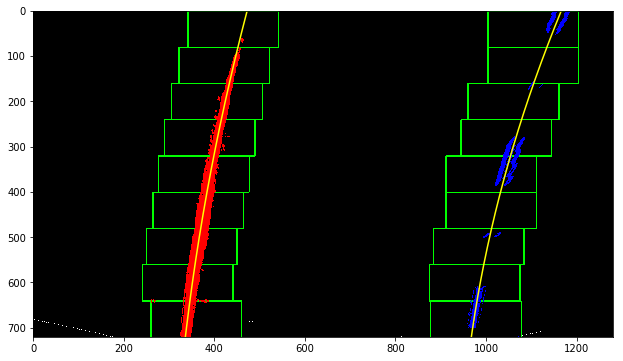

In [461]:
### Detect lane pixels and fit to find the lane boundary.

# detect_lane_lines
# global line_detected
# line_detected = False
# global left_fit, right_fit
# left_fit, right_fit = None,None
# find_lane_lines
# global glb_left_fit, glb_right_fit
# glb_left_fit = None
# glb_right_fit = None
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
detected_line=False
left_fit, right_fit=None,None

out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined_binary)

# if left_fit is not None or right_fit is not None:
#     detected_line = True
# else:
#     detected_line = False

print(detected_line)

ploty = np.linspace(0, combined_binary.shape[0]-1, combined_binary.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(15,6))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

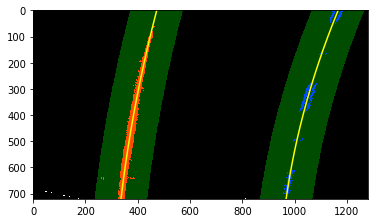

In [443]:
margin=100
out_img = np.dstack((combined_binary, combined_binary, combined_binary))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# green_shaded_margin(combined_binary)

#### 6. Determine the curvature of the lane and vehicle position with respect to center.


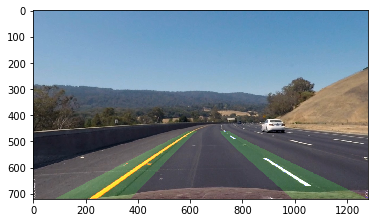

In [444]:
_, _, unwarped = get_perspective_transform(result, dst, src)
undist_cp = np.copy(undist)
final = cv2.addWeighted(undist_cp, 1, unwarped,0.5,0)
plt.imshow(final)

In [462]:
def get_curvature(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    return (left_curverad, right_curverad)

def get_center(img, ploty, left_fit, right_fit):
    ymax = np.max(ploty)
    xm_per_pix = 3.7/700 # meters per px in x-dim (conversions in x,y from pixels space to meters)
    left = left_fit[0]*ymax**2 + left_fit[1]*ymax + left_fit[2]
    right = right_fit[0]*ymax**2 + right_fit[1]*ymax + right_fit[2]
    center = (left + right) / 2
    return (img.shape[1]/2 - center)*xm_per_pix

def draw_lines(img, leftx, lefty, rightx, righty, window_height = 80):
    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_points = np.vstack(([left_fitx.T], [lefty.T])).T
    right_points = np.vstack(([right_fitx.T], [righty.T])).T
    all_points = np.concatenate((left_points, right_points[::-1]))

    cv2.fillConvexPoly(img, np.int32([all_points]), (0, 255, 0))
    
    cv2.polylines(img, np.int32([left_points]), False, (255, 0, 0), 20)
    cv2.polylines(img, np.int32([right_points]), False, (255, 0, 0), 20)        
    return img

def draw_lane(img, leftx, rightx, lefty, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]

    left_poly = np.array([np.transpose(np.vstack([left_fitx,lefty]))])
    right_poly = np.array([np.flipud(np.transpose(np.vstack([right_fitx,righty])))])
    lane_poly = np.hstack((left_poly,right_poly))

    window_img = np.zeros_like(img)
    cv2.polylines(window_img,np.int32(left_poly),1,(255,0,0),50)
    cv2.polylines(window_img,np.int32(right_poly),1,(255,0,0),50)
    out_img = cv2.fillPoly(window_img,np.int_([lane_poly]),(0,255,0))
    
    return out_img
    

In [472]:
def pipeline_process(img):
#     src = np.float32([[585,460], [203,720],
#             [1127,720], [695,460]])
#     dst = np.float32([[320,0], [320,720],
#             [960,720], [960,0]])

    src = np.float32([[585,460], [203,720],
            [1127,720], [695,460]])
    dst = np.float32([[320,0], [320,720],
            [960,720], [960,0]])

    combined_binary, warped, M, Minv, undist = apply_binary(img, src, dst)

    out_img, left_lane_inds, right_lane_inds, leftx, lefty, rightx, righty, left_fit, right_fit, nonzerox, nonzeroy = find_lane_lines(combined_binary)

    global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
#     detected_line=False
    
#     if left_fit is not None and right_fit is not None:
#         detected_line = True
#     else:
#         detected_line = False
    
    
    
    drawwarped = draw_lines(np.zeros_like(warped), leftx, lefty, rightx, righty)
#     drawwarped = draw_lane(np.zeros_like(warped), leftx, rightx, lefty, righty)
    _, _, unwarped = get_perspective_transform(drawwarped, dst, src)
    output = cv2.addWeighted(undist, 1, unwarped, 0.3, 0.0)
    
    left_curverad, right_curverad = get_curvature(lefty, leftx, lefty, rightx, righty, left_fit, right_fit)
    curvature = min([left_curverad, right_curverad])
    text = "Curvature of Radius: {:.2f} m".format(curvature)
    cv2.putText(output, text, (450,80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    text1 = "Left curve: {:.2f}".format(left_curverad)
    cv2.putText(output, text1, (450,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    text1 = "Right curve: {:.2f} m ".format(right_curverad)
    cv2.putText(output, text1, (450,260), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
#     text1 = "Detected Line {:}".format(detected_line)
#     cv2.putText(output, text1, (450,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    pos = get_center(img, ploty, left_fit, right_fit)
    if pos < 0:
        text = "Vehicle is {:.2f} m on left".format(-pos)
    else:
        text = "Vehicle is {:.2f} m on right".format(pos)
    cv2.putText(output, text, (450,140), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    return output


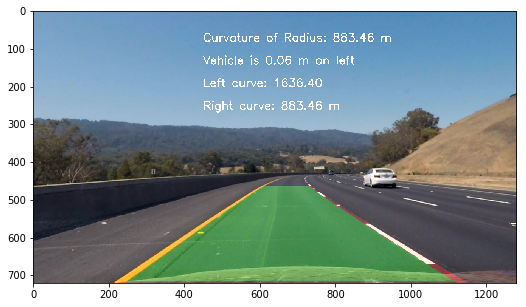

In [473]:
# global line_detected
# line_detected = False
# global left_fit, right_fit
# left_fit, right_fit = None,None
# global glb_left_fit, glb_right_fit
# glb_left_fit = None
# glb_right_fit = None
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
detected_line=False
left_fit, right_fit=None,None
output = pipeline_process(img)
plt.figure(figsize=(15,5))
plt.imshow(output)

#### 7. Warp the detected lane boundaries back onto the original image.


#### 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [467]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip('project_video.mp4')
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
detected_line=False
left_fit, right_fit=None,None
project_clip = clip1.fl_image(pipeline_process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:22<00:00,  4.69it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 6min 27s, sys: 37 s, total: 7min 4s
Wall time: 4min 23s


In [418]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'challenge_video_output.mp4'
clip1 = VideoFileClip('challenge_video.mp4')
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
detected_line=False
left_fit, right_fit=None,None
project_clip = clip1.fl_image(pipeline_process)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|██████████| 485/485 [01:24<00:00,  5.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 15s, sys: 11 s, total: 2min 26s
Wall time: 1min 24s


In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
project_output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')
global detected_line, left_fit, right_fit, left_fit_poly, right_fit_poly
detected_line=False
left_fit, right_fit=None,None
project_clip = clip1.fl_image(pipeline_process)
%time project_clip.write_videofile(project_output, audio=False)